In [1]:
%pylab inline
import ismdensgen as ism
reload(ism)

#For timing purposes
import time as tm
import datetime as dt

#Fiddling with maps
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import Angle
from astropy import units as u
from scipy import stats
import astropy
import ConfigParser

mpl.rcParams['figure.figsize'] = [6.0, 5.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

path = '../Feedback_Diagnostics/'

#If you try different stylesheets and then want to revert to the 
#Version 2.0 style of Matplotlib, use the following code

#>>> mpl.rcParams.update(mpl.rcParamsDefault)

Populating the interactive namespace from numpy and matplotlib


## Function Definitions

In [2]:
def show_pixels_on_Hmap(xp=[], yp=[], xp_comp=[], yp_comp=[], m33_map=[], label_RA_Dec=True):
    """
    Show any set of pixels on the 21 cm HI map of M33 (Gordon 2012)
    
    Input
    ------
    xp, yp - list or ndarray
        pixels to be plotted
        
    xp_comp, yp_comp - list or ndarray 
        pixels to be compared to xp, yp
    """
    
    i0, j0, width, height = ism.GordonSurveyArea()
    
    plt.figure(figsize=(9,7))
#   plt.rc('font', family='serif')
    H2imgplot = plt.imshow(m33_map/1.0e21, cmap='Greys', origin='lower')
    H2imgplot.set_clim(1.0e19/1.0e21,8.0e21/1.0e21)
    #plt.plot(coords[0][:,0], coords[0][:,1], 'bx',ms=7,mew=1.2,label='Chomiuk09')
    #plt.plot([383], [472], 'ro',ms=6, label='J2000 center')
    #plt.text(200,270, 'G99 survey', fontsize=12)
    ax = plt.gca()
    ax.add_patch(mpl.patches.Rectangle((i0,j0),width=width, height=height, fill=False, color='k', linestyle='dashed',\
                                       linewidth=2))
    #plt.plot(coords[0][:,0], coords[0][:,1], 'x',color='r',ms=6,mew=1.2, label='Chomiuk &\nWilcots (2009)')
    plt.plot(xp,yp, 'x', ms=4)
    plt.plot(xp_comp, yp_comp, 'o')
#    plt.title('HI (21cm) map for M33 (Braun 2012)', fontsize=17, position = (0.5, 1.02))
    #hcbar = plt.colorbar(orientation='horizontal', ticks = [1.0, 3.0, 5.0, 7.0], pad=0.13, shrink =0.86)
    #hcbar.set_label(r'HI Density [$\times\ 10^{21}\ \rm{cm^{-2}}$]', fontsize=12)
    plt.tick_params(axis='y', labelsize='17', which='major')
    ax.set_xlabel(r'$\alpha_{2000}$',fontsize=17)
    ax.set_ylabel(r'$\delta_{2000}$',fontsize=17)
    plt.xlim(120,650)
    plt.ylim(170,800)
    plt.text(150, 265, 'Gordon (1999)\nsurvey area', fontsize=14)
    plt.legend(loc=1, numpoints=1, fontsize=14, bbox_to_anchor=(1.5, 1.02))
    ax.set_xticks([200,400,600])
    ax.set_yticks([300,500,700])
    #ax.grid()
    if label_RA_Dec:
        ax.set_yticklabels([r'$\mathrm{30^{o}16}$'+'\''+r'$\mathrm{28}$'+'\"',\
                             r'$\mathrm{30^{o}43}$'+'\''+r'$\mathrm{15}$'+'\"',\
                             r'$\mathrm{31^{o}9}$'+'\''+r'$\mathrm{54}$'+'\"'], rotation='vertical', fontsize=17)
        ax.set_xticklabels([r'$\mathrm{1^{h}35^{m}43^{s}}$', r'$\mathrm{1^{h}33^{m}40^{s}}$', r'$\mathrm{1^{h}31^{m}36^{s}}$'], fontsize=17)
    plt.grid()
    plt.show()

def averageColDensities(a, b, array, averRadius=100.):
    """
    Returns the mean column density around the SNR.
    """
    a, b = a-1, b-1
    sky_size_per_pix = 32.6 #pc, from FeedbackMap.ipynb
    pix_in_rad = np.ceil(averRadius/sky_size_per_pix).astype('int')
    nx,ny = array.shape
    y,x = np.ogrid[-a:nx-a,-b:ny-b]
    mask = x*x + y*y <= pix_in_rad*pix_in_rad
    array[mask]=0
    return array
   # return(sum(array[mask]))
    
def nh(rho_col, z0, sntype='ia'):
    pc = 3.086e18
    zstarCC = 90.0 #pc                                                                                                                                        
    zstarIa = 320.0
    z = np.random.laplace(loc=0., scale=zstarIa, size=1) if type=='ia' else np.random.laplace(loc=0., scale=zstarCC, size=1)

    n_z = (rho_col/(pc*z0*np.sqrt(3.14)))*np.exp(-(z**2)/(z0**2))
    #return 0. if n_z < 1.0e-3 else n_z[0]
    return n_z[0]

def p0_units(mej, ekin):
    return 10028.0*np.sqrt(mej*ekin)

def p_r_final(nh, mej, ekin):
    Z = 1. #Z_sun
    r0 = 0.97*(Z**(0.046))*(mej**0.33)*((nh/100.)**(-0.33)) #Z in solar metallicity, nh in cm^{-3}
    rb = 4.0*(Z**(-0.077))*((nh/100.)**(-0.43))
    
    return p0_units(mej, ekin)*((rb/r0)**1.5)

In [3]:
n0 = [nh(NH, 200.) for NH in np.array([1.0, 1.5, 2.0, 2.5])*1.0e21]
print n0

[0.84101629173031633, 1.1524258601104165, 1.7670478983605939, 0.14839984360970326]


### 1.1 Diagnostic checks on whether the averaging scheme works

I'll make the momentum maps in two ways - first way is to calculate momentum injection in the in-situ ISM density. The other is to use density averaged over a given radius. The second method is more appropriate because SNRs will encounter various density gradients.

I want to convert averaging radius in pc to pixels using the simple relation: 1 pixel = 32.6 pc across. This is what I found in `FeedbackMap.ipynb`. You can also do this in world coordinates, but I think this is a quick check for now.

/Users/sumits2k/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


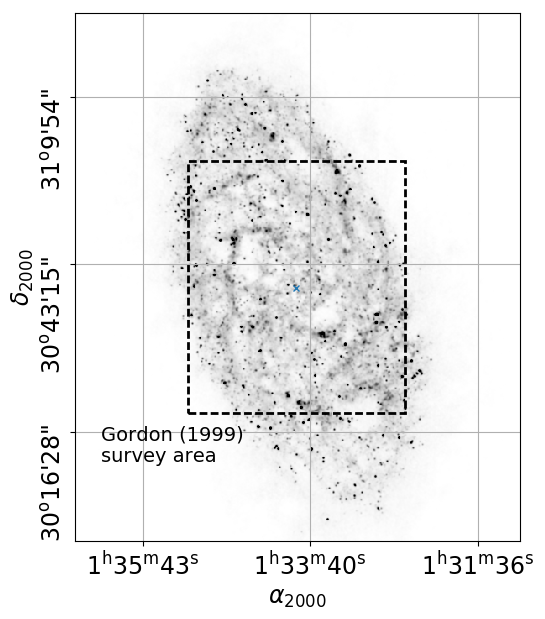

In [4]:
from astropy.wcs import WCS
from astropy.io import fits
import astropy
import ConfigParser
Config = ConfigParser.ConfigParser() 
Config.read('config.ini')
path_to_file = Config.get('InputFiles','path')
hfile = Config.get('InputFiles','hydrogenmap')
w = WCS(path_to_file+hfile)
m33_map, m33_header = fits.getdata(path_to_file+hfile, 0, header=True) #Getting the fits header file 

#We only want pixels within the Gordon Area
i0, j0, width, height = ism.GordonSurveyArea() #0th pixel with width and height of Gordon area in pixel

ra_cen = Angle('01h33m50.02s')
dec_cen = Angle('30d39m36.7s')
ra_offset, dec_offset = Angle('20m'), 0

rand_pix = [253+0, 323+height]
pix_cen = w.wcs_world2pix([[ra_cen.degree, dec_cen.degree, 0]], 1).squeeze()[:-1]
pix_cen_offset = w.wcs_world2pix([[(ra_cen + ra_offset).degree, (dec_cen + dec_offset).degree, 0]], 1).squeeze()[:-1]
                    #Because M33 FITS file has NAXIS=3, I have the extra argument = 0. The returned ndarray is 
                    #'squeezed' into a 1D array, and we discount the last element, which is the extra argument = 0.
pix_cen = np.asarray(pix_cen, dtype='int')


show_pixels_on_Hmap(pix_cen[0], pix_cen[1],m33_map=m33_map[0])

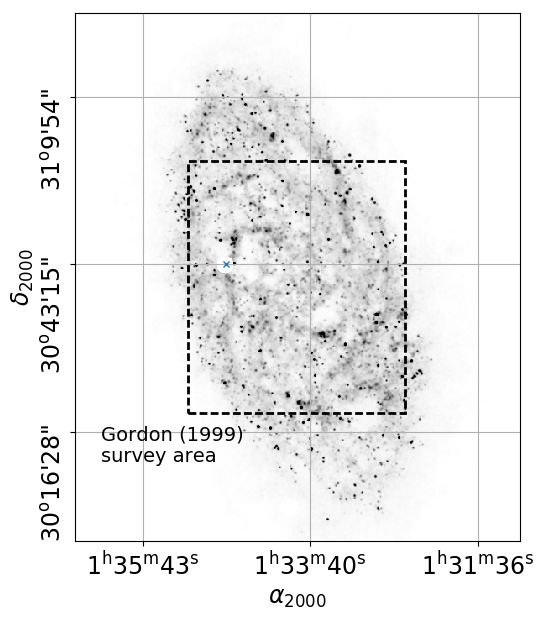

In [5]:
arr = averageColDensities(500, 300, np.copy(m33_map[0]), averRadius=300.)
show_pixels_on_Hmap([300], [500],m33_map=arr, label_RA_Dec=True)


Okay, it seems the averaging area is being picked properly. I'm a little tired of checking over and over again if its correct, so I'll shelf this for now, and go ahead with the map calculation. **IDEA**: Pick a point from the map where you see e.g. dark spots. Look at the density histogram from this region extract by your module, and see if it consistent visually with how the region looks in the map.

Make sure to calculate the mean density in **log**-space, since the column densities are more consistent log-normal.

Do the maps for both *"averaged"* (average column density over a certain radius) and *in-situ* (density equals the density of the pixel where SN occurs) cases

### 1.2 Momenta distributions

Lets use the default ISM model from Sarbadhicary (2017). I want to see the distribution of momemtums we get.

In [4]:
locx_ia = np.loadtxt('../Inputs/randompixels_x_ia.txt').astype('int')
locy_ia = np.loadtxt('../Inputs/randompixels_y_ia.txt').astype('int')
locx_cc = np.loadtxt('../Inputs/randompixels_x.txt').astype('int')
locy_cc = np.loadtxt('../Inputs/randompixels_y.txt').astype('int')

In [5]:
hmap = ism.ISMData()[0]
[x,y,width,height] = ism.GordonSurveyArea()
hmap_Gord = hmap[y:y+height+1, x:x+width+1]

h1_ia_pdf = hmap_Gord[locy_ia, locx_ia]
h1_cc_pdf = hmap_Gord[locy_cc, locx_cc]

#Remove negative values                                                                                                                                       
h1_ia_pdf = h1_ia_pdf[np.where(h1_ia_pdf>0)]
h1_cc_pdf = h1_cc_pdf[np.where(h1_cc_pdf>0)] #For some reason, this one has a few negative values.

#Create a larger set   
#This should be the last step to create two equal sized arrays, because the CC PDF
#has a few negative values removed from it.
h1_ia_rand = np.random.choice(h1_ia_pdf, size=1000000)
h1_cc_rand = np.random.choice(h1_cc_pdf, size=1000000)

In [6]:
nh_ia = np.array([nh(h1_ia, 200., sntype='ia') for h1_ia in h1_ia_rand])
nh_cc = np.array([nh(h1_cc, 200., sntype='cc') for h1_cc in h1_cc_rand])

In [7]:
e51_ia_same = np.ones(1000000)*1.0 #0.4 variance ensures Hypernova, PISNs etc occur 1/1000 times "normal" CCSN (Janka 2012)    \
e51_cc_same = np.ones(1000000)*1.0

e51_ia = 10**(np.random.normal(loc = 51.0, scale = 0.1, size = 1000000) - 51.0) #0.4 variance ensures Hypernova, PISNs etc occur 1/1000 times "normal" CCSN (Janka 2012)    \
e51_cc = 10**(np.random.normal(loc = 51.0, scale = 0.28, size = 1000000) - 51.0)

pfin_ia_same = p_r_final(nh_ia, 1.4, e51_ia_same)
pfin_cc_same = p_r_final(nh_cc, 5.0, e51_cc_same)
pfin_ia = p_r_final(nh_ia, 1.4, e51_ia)
pfin_cc = p_r_final(nh_cc, 5.0, e51_cc)
#Momentum scaling relations

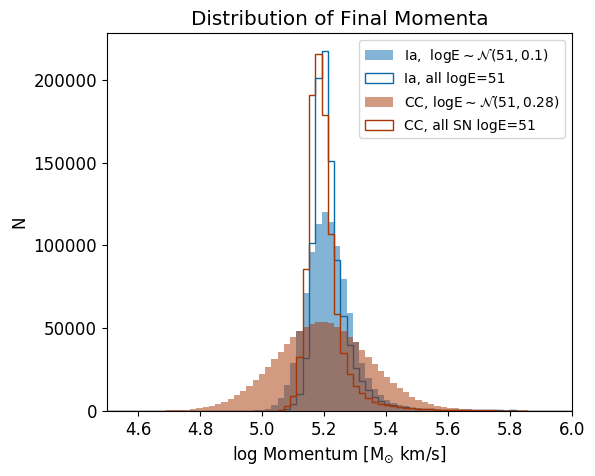

In [19]:
#~~~~~~~~~~Save Plot ~~~~~~~~~~~~~~~~#
plot_file = 'MomentaPDF_logNormE.png'
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

mu_logp_ia = np.log10(p0_units(1.4, 1.0))+1.5*np.log10((4.0/0.97)*((1.08/100.)**(-0.1)))
sigma_logp_ia = 0.5*0.1
mu_logp_cc = np.log10(p0_units(5.0, 1.0))+1.5*np.log10((4.0/0.97)*((1.5/100.)**(-0.1)))
sigma_logp_cc = 0.5*0.28

x_logp = np.linspace(4,7, 2000)
p_x_cc = 19000.*stats.norm.pdf(x_logp, mu_logp_cc, sigma_logp_cc)
p_x_ia = 15000.*stats.norm.pdf(x_logp, mu_logp_ia, sigma_logp_ia)


bins = np.linspace(4, 6, 100)

plt.hist(np.log10(pfin_ia), bins=bins, color='#0868ac', alpha=0.5, label='Ia,  logE$\sim\mathcal{N}(51, 0.1)$')
plt.hist(np.log10(pfin_ia_same), bins=bins, histtype='step', color='#0868ac',label='Ia, all logE=51')
plt.hist(np.log10(pfin_cc), bins=bins, color='#a63603', alpha=0.5, label='CC, logE$\sim\mathcal{N}(51, 0.28)$')
plt.hist(np.log10(pfin_cc_same), bins=bins, histtype='step', color='#a63603', label='CC, all SN logE=51')
plt.title('Distribution of Final Momenta')
#plt.text(5.55, 200000, r'$\langle P \rangle \propto \sqrt{M_{ej} E}$')
if 0:
    plt.plot(x_logp, p_x_cc, 'k-', alpha=0.5, lw=3.0, label='rough best-fit PDF')
    plt.plot(x_logp, p_x_ia, 'k-', alpha=0.5, lw=3.0)
plt.ylabel('N')
plt.xlabel(r'log Momentum [M$_{\odot}$ km/s]')
plt.xlim(4.5, 6)
#plt.ylim(0, 150000)
plt.legend(loc=1, fontsize=10)
#plt.savefig(path+plot_file)
plt.show()



So it seems these are basically tracing the energy distributions. The peak of SN Ia is shifted because of the lower ejecta mass, and smaller because of the smaller variance. We can fit an analytical log-normal through this plot. You can calculate $\mu_P$ for $\mu_E = 10^{51}$ ergs, and $\sigma_E$ from error propagation. Create PDF with those parameters, multiply by $10^6$ and compare with both for Ia and CC.

**Update** - ^^^ is not so simple. The final momentum $P_{fin}$ is roughly an order of magnitude higher than $P_0$ because of the $(R_b/R_0)^{1.5}$ term. So the mean won't be the same as $P_0$. I modified the code slightly - did the error propagation by hand, assumed constant ISM density, and made the broad-brush fits in gray.

But this shows that the distribution will roughly depend more on the explosion parameters, and less on the density. This is interesting. So the momentum map will be more sensitive to the distribution of energies and ejecta masses we assume. In fact, we can't assume constant ejecta mass anymore. 

In [9]:
np.log10(p0_units(5.0, 1.0))+1.5*np.log10((4.0/0.97)*((1.5/100.)**(-0.1)))

5.547218024188413

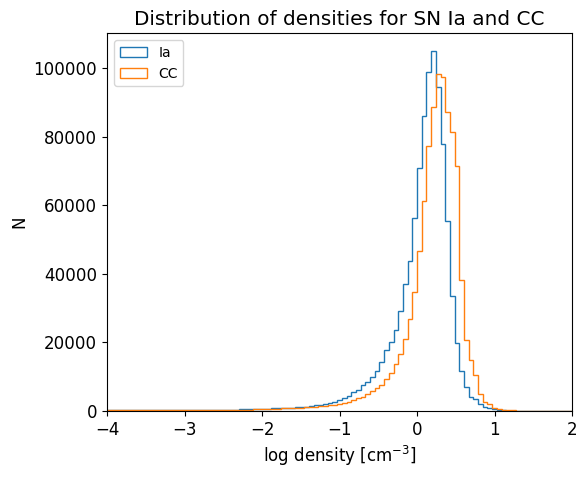

In [9]:
bins = np.linspace(-4, 2, 100)
plt.hist(np.log10(nh_ia), bins=bins, histtype='step', label='Ia')
plt.hist(np.log10(nh_cc), bins=bins, histtype='step', label='CC')
plt.title('Distribution of densities for SN Ia and CC')
plt.xlabel(r'log density [cm$^{-3}$]')
plt.ylabel('N')
plt.xlim(-4, 2)
plt.legend(loc=2, fontsize=10)
plt.show()


## 1.3 Momentum maps

Lets try to get momentum maps.

Number of SNe in 4.0 Myrs =  (12197,)
Expected #of SNe in 4.0 Myrs (rate x time) =  12000.0


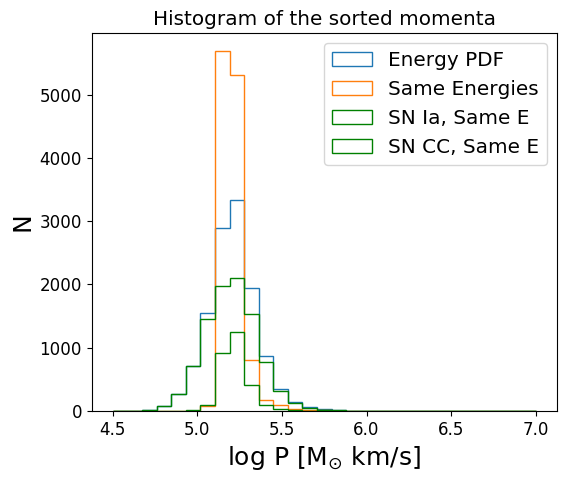

(9406,) (9406,) (9406,)


In [10]:
frac_Ia2CC, rate = 0.3, 3.0e-3
rate_Ia = rate*(frac_Ia2CC/(1 + frac_Ia2CC))
rate_CC = rate*(1./(1 + frac_Ia2CC))
t_Ia = ism.timegen(rate_Ia)
t_CC = ism.timegen(rate_CC)
locx_Ia_new, locy_Ia_new = locx_ia[:t_Ia.size], locy_ia[:t_Ia.size]
locx_CC_new, locy_CC_new = locx_cc[:t_CC.size], locy_cc[:t_CC.size]


#Sort the Ia and CC SNe in order of when they formed.
t = np.concatenate([t_Ia, t_CC])
locx = np.concatenate([locx_Ia_new, locx_CC_new])
locy = np.concatenate([locy_Ia_new, locy_CC_new])
pfin_same = np.concatenate([pfin_ia_same[0:t_Ia.size], pfin_cc_same[0:t_CC.size]])
pfin = np.concatenate([pfin_ia[0:t_Ia.size], pfin_cc[0:t_CC.size]])

args = np.argsort(t)
sorted_t = t[args]  #Here sorted means time-sorted
sorted_pfin_same = pfin_same[args]
sorted_pfin = pfin[args]
sorted_locx = locx[args]
sorted_locy = locy[args]

avgint = [1.0e6, 5.0e6]
avgfact = (avgint[-1]-avgint[0])/1.0e6
whr_sn_avgint = np.where((sorted_t >=avgint[0]) & (sorted_t <= avgint[1])) #Number of supernova that went off 
                                                                                #during the averaging interval
print 'Number of SNe in {} '.format(avgfact)+'Myrs = ', sorted_t[whr_sn_avgint].shape
print 'Expected #of SNe in {} '.format(avgfact)+'Myrs (rate x time) = ', avgfact*1.0e6*rate
sorted_pfin_avgint = sorted_pfin[whr_sn_avgint]
sorted_pfin_same_avgint = sorted_pfin_same[whr_sn_avgint]
sorted_locx_avgint = sorted_locx[whr_sn_avgint]
sorted_locy_avgint = sorted_locy[whr_sn_avgint]


plt.title('Histogram of the sorted momenta')
bins = np.linspace(4.5, 7.0, 30)

plt.hist(np.log10(sorted_pfin_avgint), bins=bins, histtype='step', label='Energy PDF')
plt.hist(np.log10(sorted_pfin_same_avgint), bins=bins, histtype='step', label='Same Energies')

if 1: #If you are interested in checking the contribution from Ia's and CC's, change this to 1. 
        #and select the appropriate distribution: pfin_same or pfin.
    pfin_ia_slice = pfin_ia[np.where((t_Ia>avgint[0]) & (t_Ia<avgint[1]))]
    locx_ia_slice = locx_ia[np.where((t_Ia>avgint[0]) & (t_Ia<avgint[1]))]
    locy_ia_slice = locy_ia[np.where((t_Ia>avgint[0]) & (t_Ia<avgint[1]))]
    
    pfin_cc_slice = pfin_cc[np.where((t_CC>avgint[0]) & (t_CC<avgint[1]))]
    locx_cc_slice = locx_cc[np.where((t_CC>avgint[0]) & (t_CC<avgint[1]))]
    locy_cc_slice = locy_cc[np.where((t_CC>avgint[0]) & (t_CC<avgint[1]))]   
    
    plt.hist(np.log10(pfin_ia_slice), bins=bins, histtype='step', color='g', label='SN Ia, Same E')
    plt.hist(np.log10(pfin_cc_slice), bins=bins, histtype='step', color='g', label='SN CC, Same E')

plt.legend()
plt.xlabel('log P [M$_{\odot}$ km/s]', fontsize=18)
plt.ylabel('N', fontsize=18)
plt.show()

print locx_cc_slice.shape, locy_cc_slice.shape, pfin_cc_slice.shape

/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log10
/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: divide by zero encountered in log10
/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log10


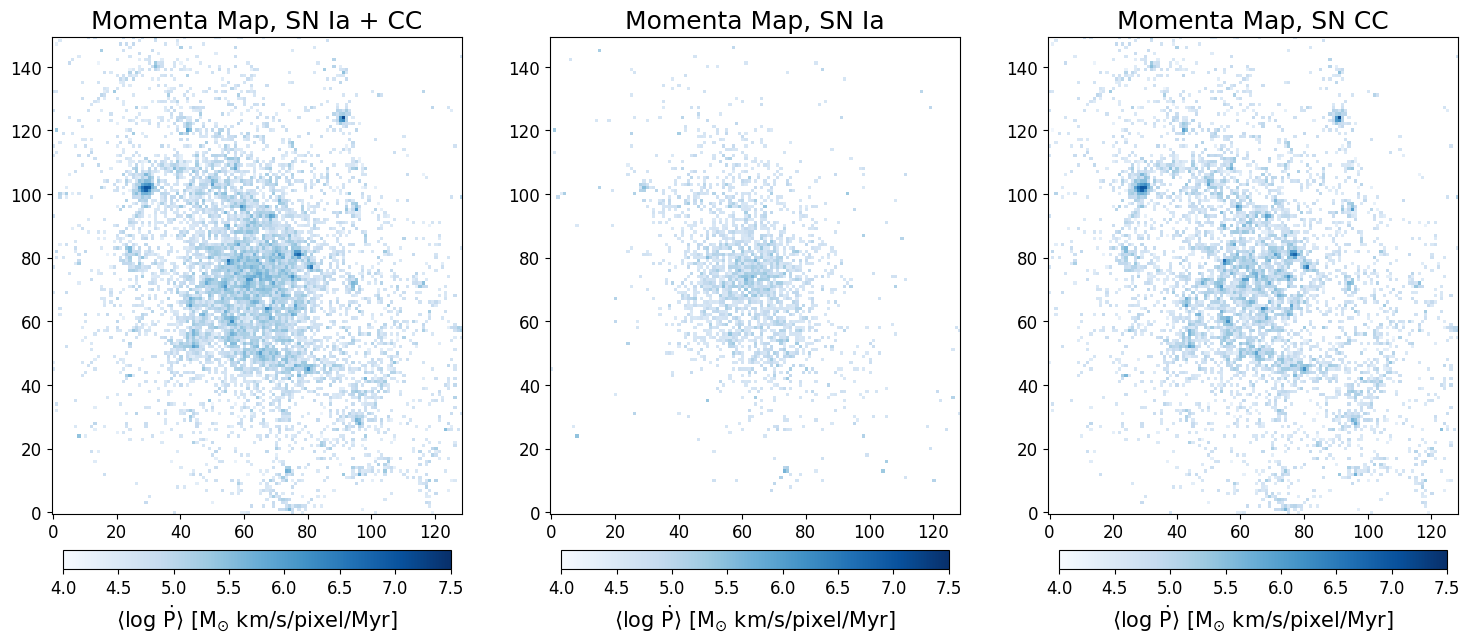

/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in log10
/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:71: RuntimeWarning: divide by zero encountered in log10
/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:81: RuntimeWarning: divide by zero encountered in log10


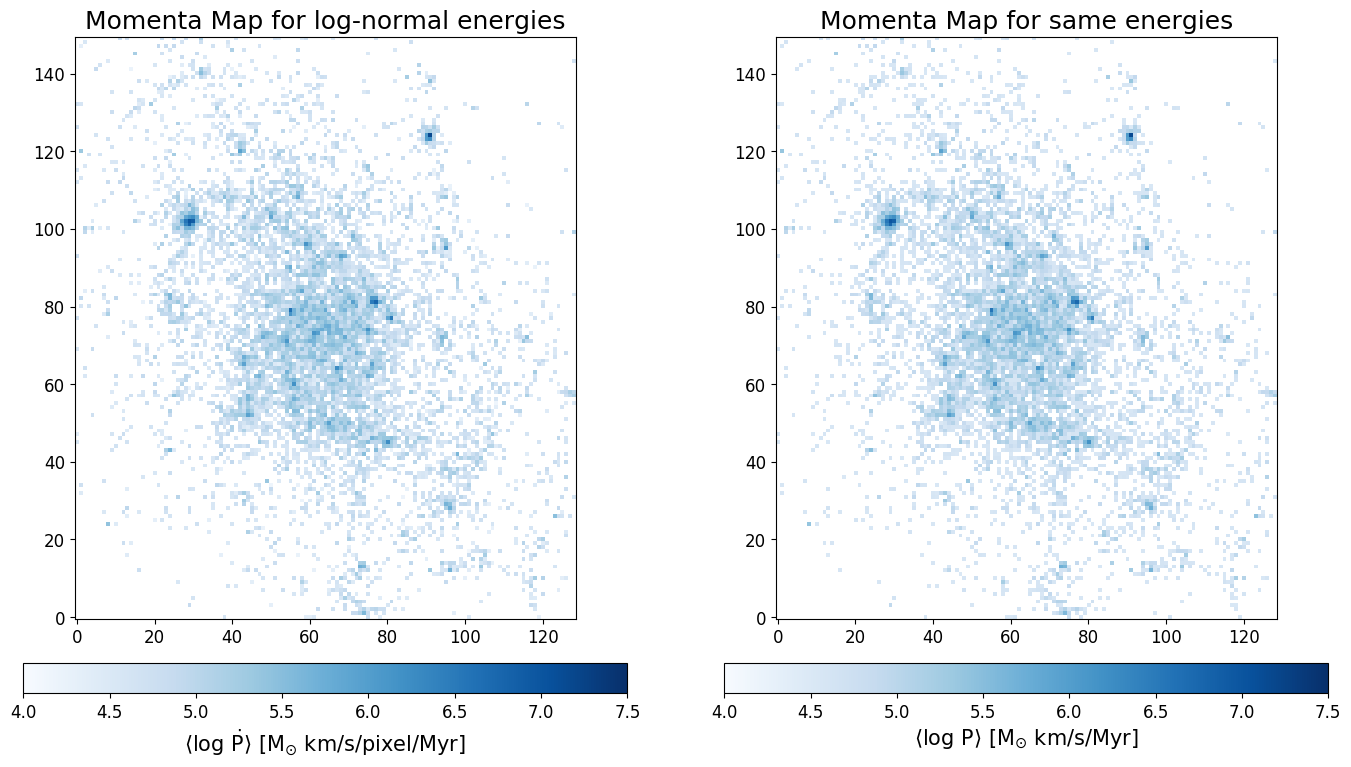

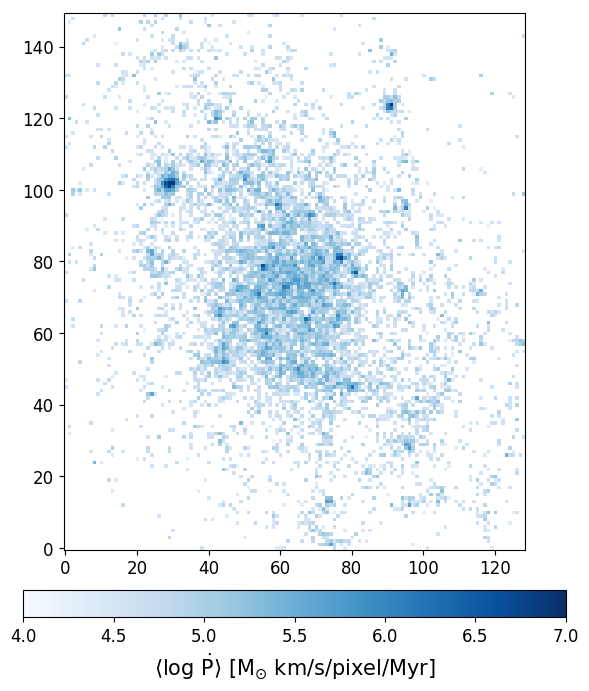

In [22]:
#~~~~~~~~~~~~Save plots ~~~~~~~~~~~~~~~~~~#
# Save them as .png files, since pixels in the .pdf look like weird Tetris blocks
#
savePlots=False
plot1_name = 'MomMaps_4MyrAvg_NoEjMass_2bin.png'
plot2_name = 'MomMaps_DistvsSameE_4MyrAvg_NoEjMass_2bin.png'
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


xbin = np.arange(0, width+1, 2) #pixel bins, with bin sizes in multiples of native pixels. 
ybin = np.arange(0, height+1, 2)

E_image = stats.binned_statistic_2d(sorted_locx_avgint, sorted_locy_avgint, sorted_pfin_avgint, 'sum', \
                                   bins=[xbin, ybin])
E_image_Ia = stats.binned_statistic_2d(locx_ia_slice, locy_ia_slice, pfin_ia_slice, 'sum', \
                                   bins=[xbin, ybin])
E_image_CC = stats.binned_statistic_2d(locx_cc_slice, locy_cc_slice, pfin_cc_slice, 'sum', \
                                   bins=[xbin, ybin])

E_image_same = stats.binned_statistic_2d(sorted_locx_avgint, sorted_locy_avgint, sorted_pfin_same_avgint, 'sum', \
                                   bins=[xbin, ybin])#This sorts the energies into each pixel bins, sums them up 
                                        #and returns a 2D image of the net energy per bin

    
#################################################
############# MOMENTA MAPS ######################
#################################################
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.imshow(np.log10(E_image.statistic.T/avgfact), origin='lower', vmin=4.0, vmax=7.5, cmap='Blues')
#Have to plot the transpose of the matrix to align with the HI image.
plt.title('Momenta Map, SN Ia + CC', fontsize=18)
cb = plt.colorbar(orientation='horizontal', pad=0.06, shrink =0.7)
cb.set_label(r'$\rm{\langle log\ \dot{P} \rangle}$ [M$_{\odot}$ km/s/pixel/Myr]', fontsize=15)

plt.subplot(1,3,2)
plt.imshow(np.log10(E_image_Ia.statistic.T/avgfact), origin='lower', vmin=4.0, vmax=7.5, cmap='Blues')
#Have to plot the transpose of the matrix to align with the HI image.
plt.title('Momenta Map, SN Ia', fontsize=18)
cb = plt.colorbar(orientation='horizontal', pad=0.06, shrink =0.7)
cb.set_label(r'$\rm{\langle log\ \dot{P} \rangle}$ [M$_{\odot}$ km/s/pixel/Myr]', fontsize=15)

plt.subplot(1,3,3)
plt.imshow(np.log10(E_image_CC.statistic.T/avgfact), origin='lower', vmin=4.0, vmax=7.5, cmap='Blues')
#Have to plot the transpose of the matrix to align with the HI image.
plt.title('Momenta Map, SN CC', fontsize=18)
cb = plt.colorbar(orientation='horizontal', pad=0.06, shrink =0.7)
cb.set_label(r'$\rm{\langle log\ \dot{P} \rangle}$ [M$_{\odot}$ km/s/pixel/Myr]', fontsize=15)

plt.subplots_adjust(wspace=-0.1)
if savePlots:
    plt.savefig(path+plot1_name)
plt.show()

#######################################################################################
############# MOMENTA MAPS - Compare same vs log-normal energies ######################
#######################################################################################
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(np.log10(E_image.statistic.T/avgfact), origin='lower', vmin=4.0, vmax=7.5, cmap='Blues')
plt.title('Momenta Map for log-normal energies', fontsize=18)
if 0:
    circle1 = plt.Circle((14,51), 3, color='r', lw=2, fill=False)
    circle2 = plt.Circle((38,40), 2, color='r', lw=2, fill=False)
    circle3 = plt.Circle((45.5,61.5), 2.5, color='r', lw=2, fill=False)
    plt.gca().add_artist(circle1)
    plt.gca().add_artist(circle2)
    plt.gca().add_artist(circle3)
   # plt.legend([circle1], ['Brightest\nHII regions'], bbox_to_anchor=(1.5,1.02), fontsize=12)
cb = plt.colorbar(orientation='horizontal', pad=0.06, shrink =0.7)
cb.set_label(r'$\rm{\langle log\ \dot{P} \rangle}$ [M$_{\odot}$ km/s/pixel/Myr]', fontsize=15)


plt.subplot(1,2,2)
plt.imshow(np.log10(E_image_same.statistic.T/avgfact), origin='lower', vmin=4.0, vmax=7.5, cmap='Blues')
plt.title('Momenta Map for same energies', fontsize=18)
cb = plt.colorbar(orientation='horizontal', pad=0.06, shrink =0.7)
cb.set_label(r'$\rm{\langle log\ P \rangle}$ [M$_{\odot}$ km/s/Myr]', fontsize=15)
plt.subplots_adjust(wspace=-0.2)
plt.tight_layout()
if savePlots:
    plt.savefig(path+plot2_name)
    
plt.figure(figsize=(10,9))
plt.imshow(np.log10(E_image.statistic.T/avgfact), origin='lower', vmin=4.0, vmax=7.0, cmap='Blues')
#Have to plot the transpose of the matrix to align with the HI image.
#plt.title('Momentum ', fontsize=18)
cb = plt.colorbar(orientation='horizontal', pad=0.06, shrink =0.7)
cb.set_label(r'$\rm{\langle log\ \dot{P} \rangle}$ [M$_{\odot}$ km/s/pixel/Myr]', fontsize=15)
plt.show()

## Correlation between final momentum and densities

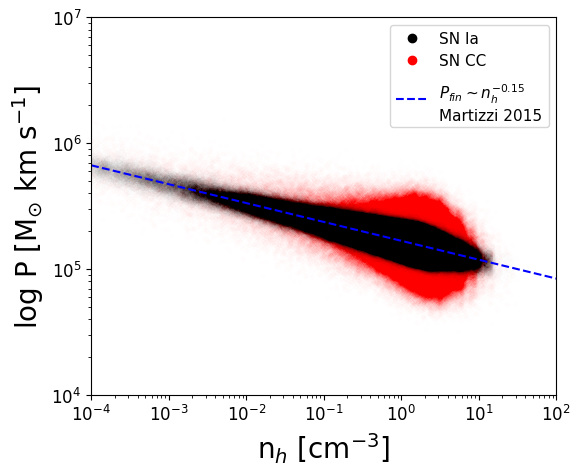

In [40]:
nharray = np.logspace(-4, 2, 100)
pr_array = p_r_final(nharray, 1.4, 1.0)

plt.scatter(nh_ia, pfin_ia, color='k', alpha=0.005)
plt.plot(nh_cc, pfin_cc, 'r.', alpha=0.005)
plt.plot(nharray, pr_array, 'b--')
plt.plot([], [], 'ko', label='SN Ia')
plt.plot([], [], 'ro', label='SN CC')
plt.plot([], [], 'b--', label=r'$P_{fin} \sim n_h^{-0.15}$'+'\nMartizzi 2015')

plt.xlabel(r'n$_h$ [cm$^{-3}$]', fontsize=20)
plt.ylabel(r'log P [M$_{\odot}$ km s$^{-1}$]', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1.0e-4, 1.0e2)
plt.ylim(1.0e4, 1.0e7)
plt.legend(fontsize=11)
plt.show()

**COMMENTS**
1. Check for column density correlations as well.
2. Histograms on top and bottom - should be same as plots from Sec 1.2
3. Scatter is the main thing to observe here.

Remember that with these maps, the main results are the correlations. With the know the known causal relations, what is the correlation between momentum injection rate, ISM density and stellar mass, taking into accoun the observational constraints on the ISM and stellar distribution, and the diversity of SNe?
   

## Binning HI maps in the same way

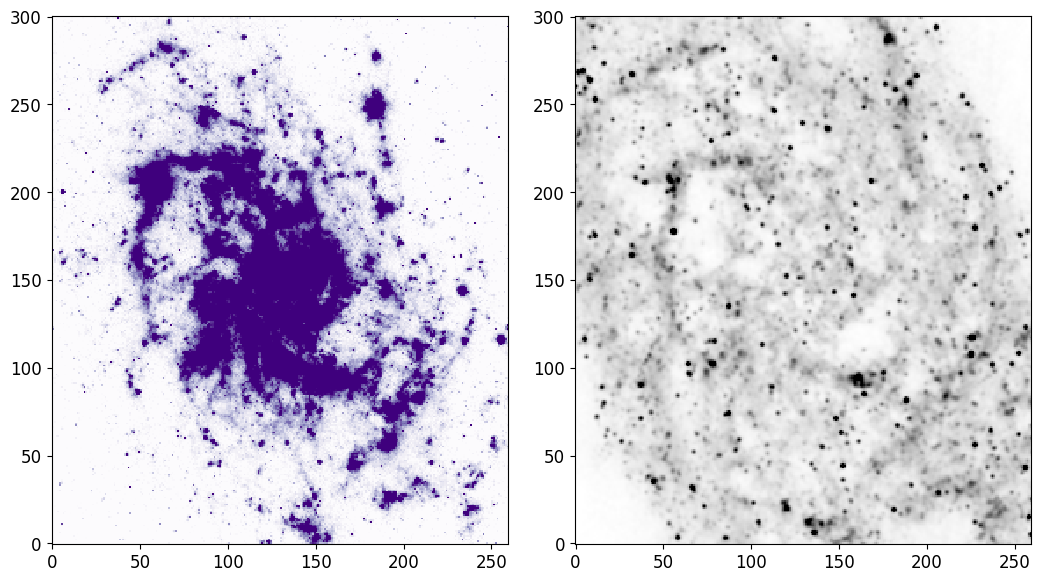

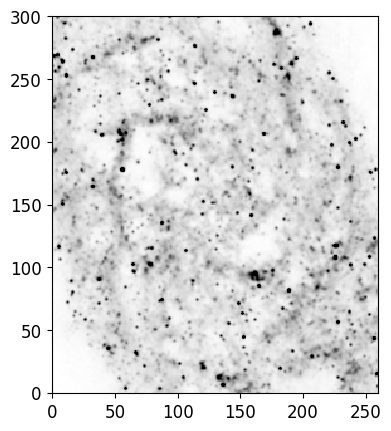

In [151]:
#~~~~~~~~~~~~Save plots ~~~~~~~~~~~~~~~~~~#
# Save them as .png files, since pixels in the .pdf look like weird Tetris blocks
#
savePlots=False
plot_name = 'HImap_UVmap_contours.png'
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

import scipy
reload(ism)
newimg = scipy.misc.imresize(hmap_Gord, size=(150, 129), mode='F')
#size is x, y, which in pixel space is (columns=height, rows=width). Sorry
#'F' is 32-bit floating point colors. This is necessary, other options won't give you a map

uvimg = ism.UVimage_corrected()
[x,y,width,height] = ism.GordonSurveyArea()
uvimg_Gord = uvimg[y:y+height+1, x:x+width+1]
new_uvimg = scipy.misc.imresize(uvimg_Gord/1.0e37, size=(150, 129), mode='F')

#Plots

plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
FUVimgplot = plt.imshow(uvimg_Gord/1.0e37, cmap='Purples', origin='lower')
FUVimgplot.set_clim(4.0e36/1.0e37,4.0e37/1.0e37)

plt.subplot(1, 2, 2)
H2imgplot = plt.imshow(hmap_Gord/1.0e21, cmap='Greys', origin='lower')
#plt.title('Width = {}'.format(width)+', Height={}'.format(height))
H2imgplot.set_clim(1.0e19/1.0e21,8.0e21/1.0e21)
#plt.contour(uvimg_Gord/1.0e37, levels=[5.0, 15.0, 30.], colors='r', alpha=0.8)

plt.subplots_adjust(hspace=0., wspace=-0.4)

if savePlots:
    plt.savefig(path+plot_name)
plt.show()

plt.figure()
H2imgplot = plt.imshow(hmap_Gord/1.0e21, cmap='Greys', origin='lower')
#plt.title('Width = {}'.format(width)+', Height={}'.format(height))
H2imgplot.set_clim(1.0e19/1.0e21,8.0e21/1.0e21)
plt.show()

**COMMENTS**

1. For the UV image, you have to divide the image by 1.0e37, otherwise the pixel values are too big, and the resizing leads to adding/multiplying (not sure which) large values which lead to infinity.

2. You might want to think of using the HGEOMC images. They were scaled to the spatial resolution of the HI image (20"). HGEOMC images appear more smeared out though, particularly for UV. Talk to Laura about this more. For the Sarbadhicary 2017 paper, I didn't want to use the smeared out images because it would have UV fluxes in areas where there are no stars, based on the higher resolution image (the UV flux is just the result of smearing out), and so CC SNe might go off in areas where they otherwise shouldn't. You can test this out by generating mock CC SN, and seeing the difference in distribution based on the two images.

3. See if you can do this for the Halpha image as well. Might be interesting to have both Pfin/L_UV and Pfin/L_Ha map.

**COMMENTS**

I wasn't quite sure if the HI and UV images were properly aligned. So I overlaid a contour map of the UV on the HI map. Quite a few structures in HI that are not correlated with UV emitting regions. Particularly there is that knot of UV in the top right corner that's not aligned with the HI knot in the same region. This is quite interesting and probably beyond the scope of my work. 

**But just to make sure, I zoomed out of both images and plotted the actual maps sent by Laura below. I deleted the code, but its not that hard to redo it.**

Seems like they are aligned. Although its weird how many of the UV and HI knots are uncorrelated.

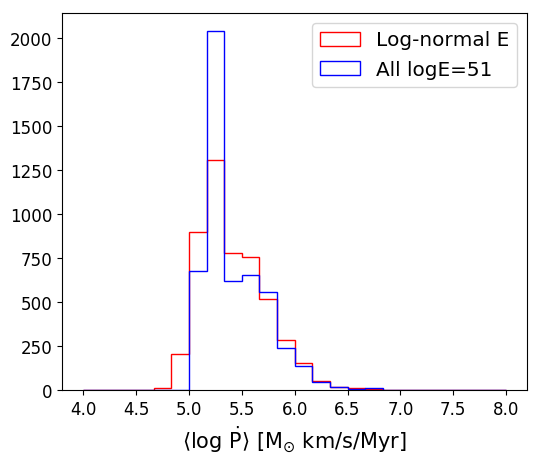

In [29]:
#~~~~~~~~~~~~Save plots ~~~~~~~~~~~~~~~~~~#
savePlots=False
plot_name = 'logPdot_Histogram.png'
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

sum_Pfin_map = E_image.statistic.T.ravel()
sum_Pfin_Ia_map = E_image_Ia.statistic.T.ravel()
sum_Pfin_CC_map = E_image_CC.statistic.T.ravel()

log_sum_Pfin_map = np.log10(sum_Pfin_map[np.nonzero(sum_Pfin_map)])
log_sum_Pfin_Ia_map = np.log10(sum_Pfin_Ia_map[np.nonzero(sum_Pfin_Ia_map)])
log_sum_Pfin_CC_map = np.log10(sum_Pfin_CC_map[np.nonzero(sum_Pfin_CC_map)])

sum_Pfin_same_map = E_image_same.statistic.T.ravel()
log_sum_Pfin_same_map = np.log10(sum_Pfin_same_map[np.nonzero(sum_Pfin_same_map)])

bins = np.linspace(4, 8, 25)
#plt.title('Momenta from map')
plt.hist(log_sum_Pfin_map, bins=bins, histtype='step', color='r', label=r'Log-normal E')
#plt.hist(log_sum_Pfin_Ia_map, bins=bins, histtype='step', color='b', label=r'SN Ia')
#plt.hist(log_sum_Pfin_CC_map, bins=bins, histtype='step', color='g', label=r'SN CC')
plt.hist(log_sum_Pfin_same_map, bins=bins, histtype='step', color='b', label=r'All logE=51')
plt.xlabel(r'$\rm{\langle log\ \dot{P} \rangle}$ [M$_{\odot}$ km/s/Myr]', fontsize=15)
plt.legend()

if savePlots:
    plt.savefig(path+plot_name)
plt.show()

In [89]:
dim1, dim2 = E_image.statistic.T.shape
print dim1, dim2

150 129


## 1.5 Correlations of $P_{fin}$ with $N_H$, $L_{FUV}$ maps

/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log10


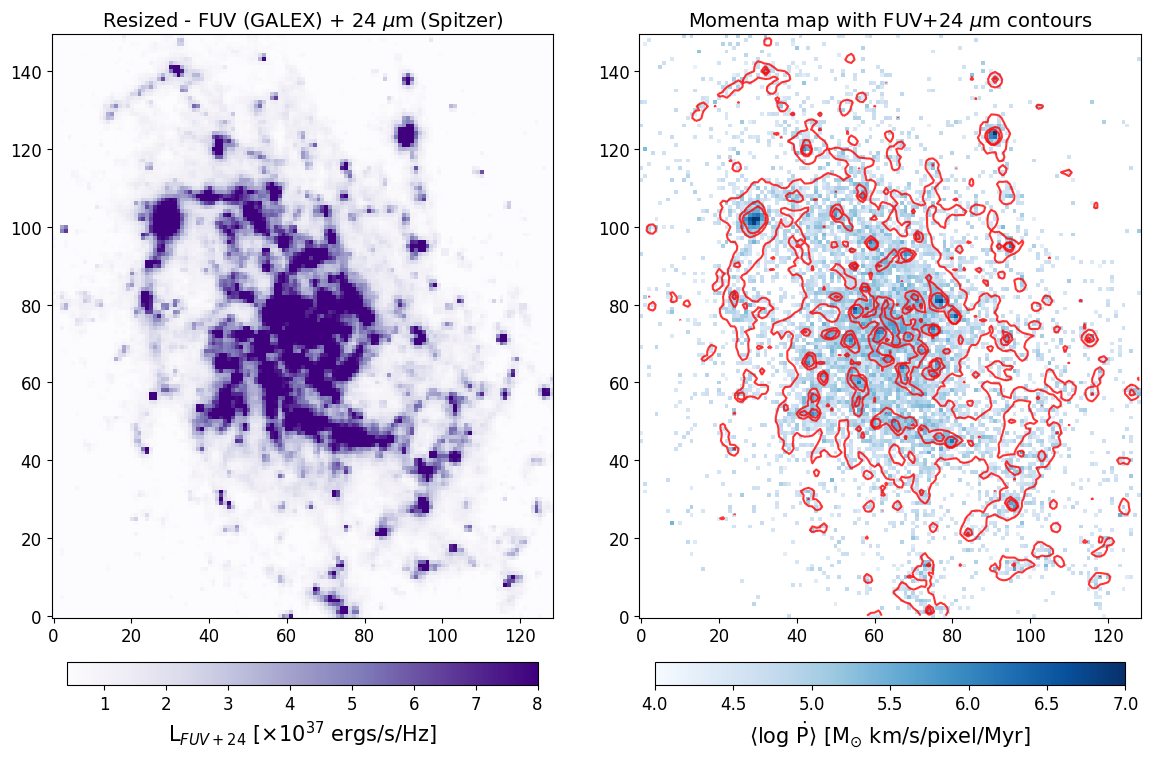

In [30]:
#~~~~~~~~~~~~ Save file ~~~~~~~~~~~~~~~~~#
savePlots = False
plot_file = 'CompareMaps_Pfin_UV.png'
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

import scipy
reload(ism)
newimg = scipy.misc.imresize(hmap_Gord, size=E_image.statistic.T.shape, mode='F')
#size is x, y, which in pixel space is (columns=height, rows=width). Sorry
#'F' is 32-bit floating point colors. This is necessary, other options won't give you a map

uvimg = ism.UVimage_corrected()
[x,y,width,height] = ism.GordonSurveyArea()
uvimg_Gord = uvimg[y:y+height+1, x:x+width+1]
new_uvimg = scipy.misc.imresize(uvimg_Gord/1.0e37, size=E_image.statistic.T.shape, mode='F')

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.title('Resized - FUV (GALEX) + 24 $\mu$m (Spitzer)', fontsize=14)
FUVimgplot = plt.imshow(new_uvimg, cmap='Purples', origin='lower')
FUVimgplot.set_clim(4.0e36/1.0e37,8.0e37/1.0e37)
cbuv = plt.colorbar(orientation='horizontal', pad=0.06, shrink=0.4)
cbuv.set_label(r'L$_{FUV+24}$ [$\times 10^{37}$ ergs/s/Hz]', fontsize=15)
#plt.contour(new_uvimg, levels=[ 10.0, 20., 30.], colors='r', alpha=0.8)

plt.subplot(1, 2, 2)
plt.title('Momenta map with FUV+24 $\mu$m contours', fontsize=14)
#plt.title('Momenta Map')
plt.imshow(np.log10(E_image.statistic.T/avgfact), origin='lower', vmin=4.0, vmax=7.0, cmap='Blues')
cb = plt.colorbar(orientation='horizontal', pad=0.06, shrink =0.4)
cb.set_label(r'$\rm{\langle log\ \dot{P} \rangle}$ [M$_{\odot}$ km/s/pixel/Myr]', fontsize=15)
plt.contour(new_uvimg, levels=[2.0, 10.0, 20.0], colors='r', alpha=0.8)
#plt.contour(np.log10(E_image.statistic.T/avgfact), levels=[4.8, 5.0, 5.2], colors='r', alpha=0.8)

plt.subplots_adjust(hspace=0., wspace=-0.7)
plt.tight_layout()

if savePlots:
    plt.savefig(path+plot_file)
plt.show()

/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10


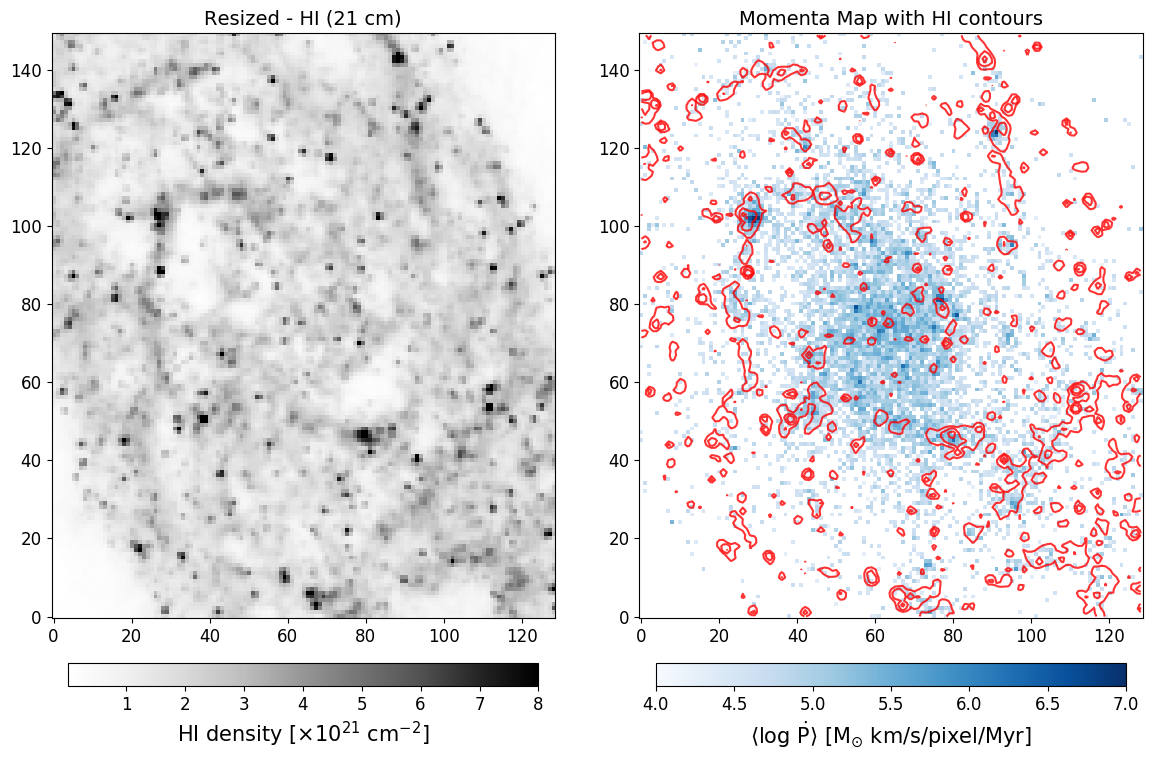

In [35]:
#~~~~~~~~~~~~ Save file ~~~~~~~~~~~~~~~~~#
savePlots = False
plot_file = 'CompareMaps_Pfin_HI_withconts_noConOnHI.png'
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.title('Resized - HI (21 cm)', fontsize=14)
H2imgplot = plt.imshow(newimg/1.0e21, cmap='Greys', origin='lower')
H2imgplot.set_clim(1.0e19/1.0e21,8.0e21/1.0e21)
cb = plt.colorbar(orientation='horizontal', pad=0.06, shrink =0.4)
cb.set_label(r'HI density [$\times 10^{21}$ cm$^{-2}$]', fontsize=15)
#plt.contour(newimg/1.0e21, levels=[3.0, 5.0, 9.0], colors='r', alpha=0.8)


plt.subplot(1, 2, 2)
#plt.title('Momenta map with FUV+24 $\mu$m contours', fontsize=14)
plt.title('Momenta Map with HI contours', fontsize=14)
plt.imshow(np.log10(E_image.statistic.T/avgfact), origin='lower', vmin=4.0, vmax=7.0, cmap='Blues')
cb = plt.colorbar(orientation='horizontal', pad=0.06, shrink =0.4)
cb.set_label(r'$\rm{\langle log\ \dot{P} \rangle}$ [M$_{\odot}$ km/s/pixel/Myr]', fontsize=15)
plt.contour(newimg/1.0e21, levels=[3.0, 5.0, 9.0], colors='r', alpha=0.8)

plt.subplots_adjust(hspace=0., wspace=-0.7)
plt.tight_layout()
if savePlots:
    plt.savefig(path+plot_file)
plt.show()

/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: overflow encountered in multiply
/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: overflow encountered in multiply
/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: overflow encountered in multiply


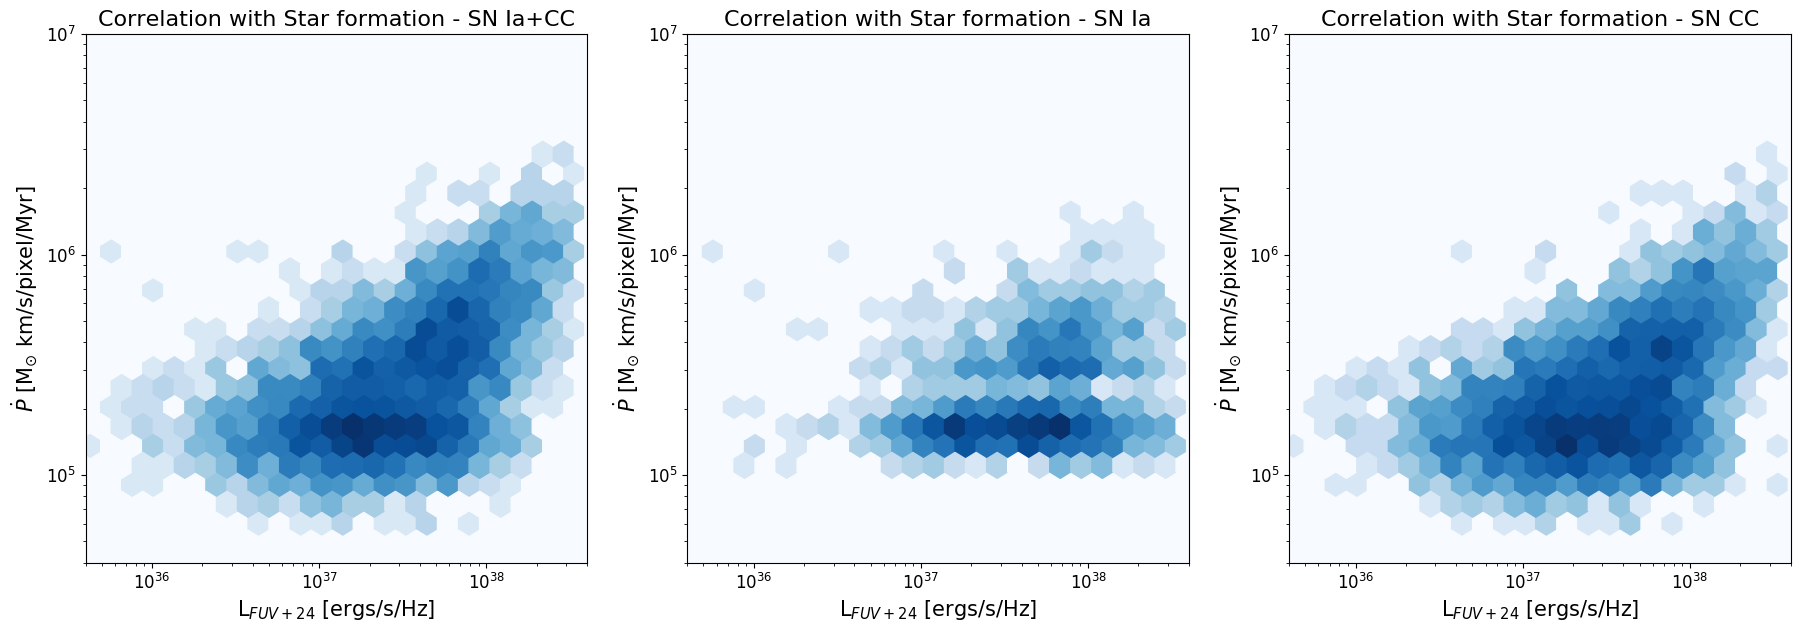

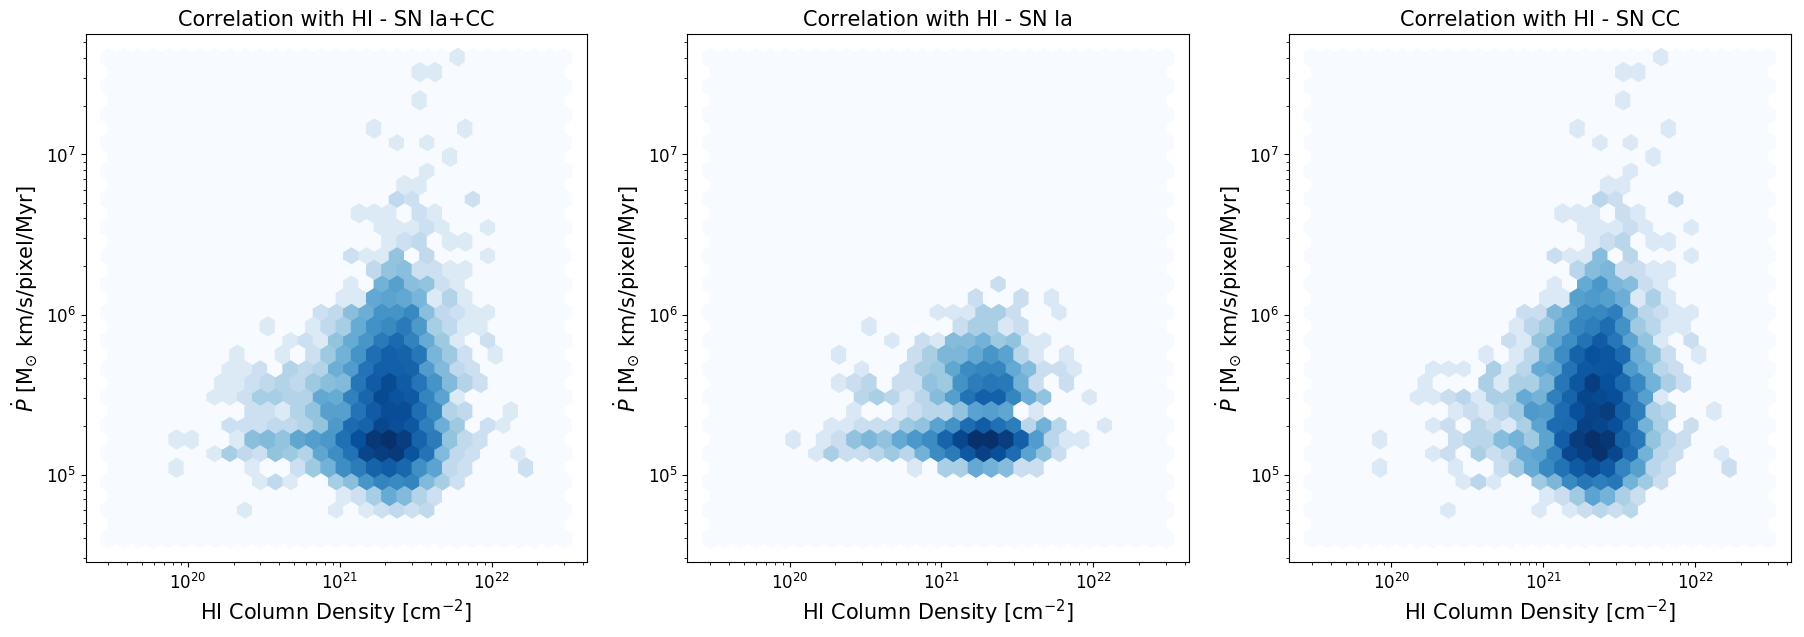

In [145]:
#~~~~~~~~~~~~ Save file ~~~~~~~~~~~~~~~~~#
savePlots = True
plot1_file = 'logPdot_FUV_hexbin_correln.png'
plot2_file = 'logPdot_HI_hexbin_correln.png'
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
def cleaned_maps(Pfin, tracer):
    Pfin_map_clean = Pfin[Pfin>0]
    tracer_map_clean = tracer[Pfin>0]
    tracer_map_final = tracer_map_clean[tracer_map_clean>0]
    Pfin_map_final = Pfin_map_clean[tracer_map_clean>0]
    return Pfin_map_final, tracer_map_final

sum_Pfin_map = E_image.statistic.T.ravel()
sum_Pfin_Ia_map = E_image_Ia.statistic.T.ravel()
sum_Pfin_CC_map = E_image_CC.statistic.T.ravel()

fuv_map = new_uvimg.ravel()
hI_map = newimg.ravel()

#In the next few steps, we have to remove zeros from the FUV and Pfin maps. Pfin map
#will contain a lot of 0s since SNe didn't go off in most of the map. UV will have some 
#negatives because of the data reduction process. This is cumbersome. We have to think of a
#better way to do this, but for now, the procedure below works with hexbin(), although some infinities
#remain somewhere. It doesn't work well with seaborn. 

Pfin_Ia_CC, fuv_Ia_CC = cleaned_maps(sum_Pfin_map, fuv_map)
Pfin_Ia, fuv_Ia = cleaned_maps(sum_Pfin_Ia_map, fuv_map)
Pfin_CC, fuv_CC = cleaned_maps(sum_Pfin_CC_map, fuv_map)

extent = [np.log10(1.0e35), np.log10(6.0e38), np.log10(4.0e4), np.log10(4.0e7)]

plt.figure(figsize=(22, 7))
plt.subplot(1,3,1)
ax = plt.gca()
ax.set_title('Correlation with Star formation - SN Ia+CC', fontsize=16)
ax.hexbin(fuv_Ia_CC*1.0e37, Pfin_Ia_CC, bins='log', xscale='log', yscale='log', extent=extent, gridsize=30, cmap='Blues')
ax.set_xlabel(r'L$_{FUV+24}$ [ergs/s/Hz]', fontsize=15)
ax.set_ylabel(r'$\dot{P}$ [M$_{\odot}$ km/s/pixel/Myr]', fontsize=15)
ax.set_ylim(4.0e4, 1.0e7)
ax.set_xlim(4.0e35, 4.0e38)

plt.subplot(1,3,2)
ax = plt.gca()
ax.set_title('Correlation with Star formation - SN Ia', fontsize=16)
ax.hexbin(fuv_Ia*1.0e37, Pfin_Ia, bins='log', xscale='log', yscale='log', extent = extent, \
          gridsize=30, cmap='Blues')
ax.set_xlabel(r'L$_{FUV+24}$ [ergs/s/Hz]', fontsize=15)
ax.set_ylabel(r'$\dot{P}$ [M$_{\odot}$ km/s/pixel/Myr]', fontsize=15)
ax.set_ylim(4.0e4, 1.0e7)
ax.set_xlim(4.0e35, 4.0e38)

plt.subplot(1,3,3)
ax = plt.gca()
ax.set_title('Correlation with Star formation - SN CC', fontsize=16)
hx = ax.hexbin(fuv_CC*1.0e37, Pfin_CC, bins='log', xscale='log', yscale='log', extent=extent, gridsize=30, cmap='Blues')
ax.set_xlabel(r'L$_{FUV+24}$ [ergs/s/Hz]', fontsize=15)
ax.set_ylabel(r'$\dot{P}$ [M$_{\odot}$ km/s/pixel/Myr]', fontsize=15)
ax.set_ylim(4.0e4, 1.0e7)
ax.set_xlim(4.0e35, 4.0e38)
#ax2.hist(uvimg_Gord.ravel(), bins=bins, histtype='step')
#ax2.hist(fuv_map[np.nonzero(fuv_map)], bins=bins, histtype='step')
#ax.set_ylim(1.0e4, 1.0e7)
#ax.set_xlim(1.0e35, 1.0e39)
plt.savefig(path+plot1_file)
plt.show()

Pfin_map_clean = sum_Pfin_map[sum_Pfin_map>0]
hI_map_clean = hI_map[sum_Pfin_map>0]
Pfin_map_Ia_clean = sum_Pfin_Ia_map[sum_Pfin_Ia_map>0]
hI_map_Ia_clean = hI_map[sum_Pfin_Ia_map>0]
Pfin_map_CC_clean = sum_Pfin_map[sum_Pfin_CC_map>0]
hI_map_CC_clean = hI_map[sum_Pfin_CC_map>0]

plt.figure(figsize=(22,7))
extent = [np.log10(3.0e19), np.log10(3.0e22), np.log10(4.0e4), np.log10(4.0e7)]
plt.subplot(1, 3, 1)
plt.title('Correlation with HI - SN Ia+CC', fontsize=15)
plt.hexbin(hI_map_clean, Pfin_map_clean, bins='log', xscale='log', yscale='log', extent=extent, gridsize=30, cmap='Blues')
plt.xlabel(r'HI Column Density [cm$^{-2}$]', fontsize=15)
plt.ylabel(r'$\dot{P}$ [M$_{\odot}$ km/s/pixel/Myr]', fontsize=15)

plt.subplot(1, 3, 2)
plt.title('Correlation with HI - SN Ia', fontsize=15)
plt.hexbin(hI_map_Ia_clean, Pfin_map_Ia_clean, bins='log', xscale='log', yscale='log', extent=extent, gridsize=30, cmap='Blues')
plt.xlabel(r'HI Column Density [cm$^{-2}$]', fontsize=15)
plt.ylabel(r'$\dot{P}$ [M$_{\odot}$ km/s/pixel/Myr]', fontsize=15)

plt.subplot(1, 3, 3)
plt.title('Correlation with HI - SN CC', fontsize=15)
plt.hexbin(hI_map_CC_clean, Pfin_map_CC_clean, bins='log', xscale='log', yscale='log', extent=extent, gridsize=30, cmap='Blues')
plt.xlabel(r'HI Column Density [cm$^{-2}$]', fontsize=15)
plt.ylabel(r'$\dot{P}$ [M$_{\odot}$ km/s/pixel/Myr]', fontsize=15)

plt.savefig(path+plot2_file)
plt.show()

## 1.6 Dissecting the Correlation Maps

The correlation maps have the basic features
1. Momentum injection is correlated with star-forming regions. Most of the momentum will come from star-forming regions.
2. CC momentum injection is more closely correlated with star-forming regions than Ia. This is not accidental, because we are after all tracing where we put CC SN in our model from maps.
3. Ia injection is less correlated with star-formation
4. Neither CC nor Ia are correlated with HI density. 

**But there are bimodalities in the correlation plots. What are these bimodalities associated with??**

/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: overflow encountered in multiply
/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log10


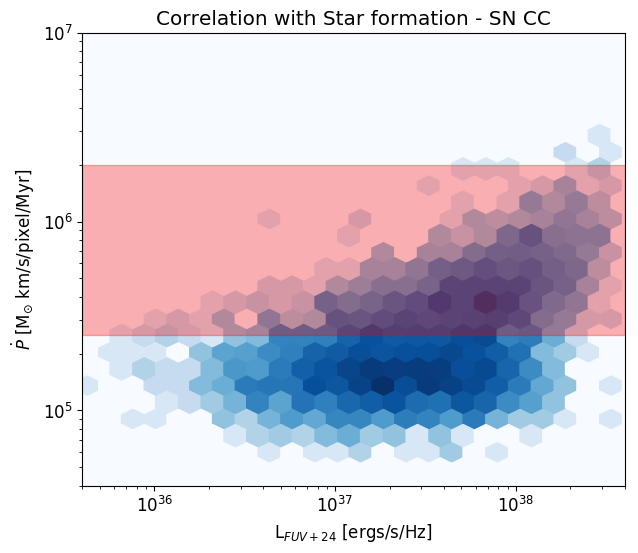

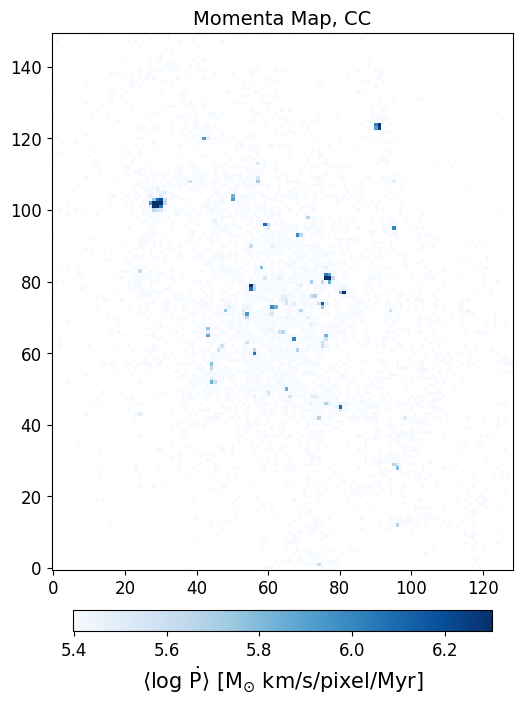

In [144]:
#~~~~~~~~~~~~~ Save Plots ~~~~~~~~~~~~~~#
savePlots = True
plot1_name = 'CorrPlot_logP_FUV_CC_logPCuts_high.png'
plot2_name = 'PfinMap_logP_FUV_CC_logPCuts_high.png'

extent = [np.log10(1.0e35), np.log10(6.0e38), np.log10(4.0e4), np.log10(4.0e7)]
vmin, vmax = 2.5e5, 2.0e6

plt.figure(figsize=(7,6))
plt.title('Correlation with Star formation - SN CC')
plt.hexbin(fuv_CC*1.0e37, Pfin_CC, bins='log', xscale='log', yscale='log',\
          extent=extent, gridsize=30, cmap='Blues')
plt.axhspan(ymin=vmin, ymax=vmax, color='r', alpha=0.3)
plt.xlabel(r'L$_{FUV+24}$ [ergs/s/Hz]')
plt.ylabel(r'$\dot{P}$ [M$_{\odot}$ km/s/pixel/Myr]')
plt.ylim(4.0e4, 1.0e7)
plt.xlim(4.0e35, 4.0e38)
if savePlots:
    plt.savefig(path+plot1_name)

plt.figure(figsize=(9,9))
#plt.title('Momenta map with FUV+24 $\mu$m contours', fontsize=14)
plt.title('Momenta Map, CC', fontsize=14)
plt.imshow(np.log10(E_image_CC.statistic.T/avgfact), origin='lower', vmin=np.log10(vmin), vmax=np.log10(vmax), cmap='Blues')
cb = plt.colorbar(orientation='horizontal', pad=0.06, shrink=0.6)
cb.set_label(r'$\rm{\langle log\ \dot{P} \rangle}$ [M$_{\odot}$ km/s/pixel/Myr]', fontsize=15)
#plt.contour(data, levels=[5.0, 6.0], colors=('r'), alpha=0.8)
if savePlots:
    plt.savefig(path+plot2_name)

plt.show()

In [122]:
data[~np.isnan(data)]

array([], dtype=float64)